In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
b_d = os.path.join("..","base_model_files")
nam_file = "freyberg.nam"

In [3]:
def redis_freyberg(fac=3):

    model_ws = b_d
    mf_nam = "freyberg.nam"

    mf = flopy.modflow.Modflow.load(nam_file, model_ws=b_d, verbose=True, version="mfnwt", exe_name="mfnwt")

    def resample_arr(arr,fac):
        new_arr = np.zeros((arr.shape[0] * fac, arr.shape[1] * fac))
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                new_arr[i*fac:(i*fac)+fac,j*fac:(j*fac)+fac] = arr[i,j]
        return new_arr


    assert fac % 2 != 0
    perlen = mf.dis.perlen
    delr = mf.dis.delr.array[0] / fac
    delc = mf.dis.delc.array[0] / fac
    redis_model_ws = "redis"
    mfr = flopy.modflow.Modflow("freyberg",model_ws=redis_model_ws,
                                version="mfnwt",exe_name="mfnwt")
    flopy.modflow.ModflowDis(mfr,nrow=mf.nrow*fac,ncol=mf.ncol*fac,nlay=mf.nlay,
                             nper=perlen.shape[0],delr=delr,delc=delc,
                             top=resample_arr(mf.dis.top.array,fac),
                             botm=[resample_arr(a,fac) for a in mf.dis.botm.array],
                             steady=False)

    flopy.modflow.ModflowBas(mfr,ibound=[resample_arr(a,fac) for a in mf.bas6.ibound.array],
                             strt=[resample_arr(a,fac) for a in mf.bas6.strt.array])

    flopy.modflow.ModflowNwt(mfr)

    oc_spd = {(iper,0):["save head","save budget"] for iper in range(mfr.nper)}
    flopy.modflow.ModflowOc(mfr,stress_period_data=oc_spd)

    flopy.modflow.ModflowUpw(mfr,laytyp=mf.upw.laytyp,hk=[resample_arr(a,fac) for a in mf.upw.hk.array],
                             vka=[resample_arr(a,fac) for a in mf.upw.vka.array],ss=0.0001,
                             sy=0.1)
    #mfr.upw.hk = 30.
    #mfr.upw.vka = 3
    #mfr.upw.hk[1] = 0.1
    #mfr.upw.vka[1] = 0.1
    rech0 = resample_arr(mf.rch.rech[0].array,fac)
    rech1 = resample_arr(mf.rch.rech[1].array,fac)
    flopy.modflow.ModflowRch(mfr,rech={0:rech0,1:rech1})

    wel_spd0 = mf.wel.stress_period_data[0].copy()
    wel_spd0["i"] = (wel_spd0["i"] * fac) + int(fac/2.0)
    wel_spd0["j"] = (wel_spd0["j"] * fac) + int(fac/2.0)
    wel_spd1 = mf.wel.stress_period_data[1].copy()
    wel_spd1["i"] = (wel_spd1["i"] * fac) + int(fac/2.0)
    wel_spd1["j"] = (wel_spd1["j"] * fac) + int(fac/2.0)
    #print(mf.wel.stress_period_data[0]["i"],wel_spd["i"])
    #print(39 * fac + int(fac/2.0))
    wel_dat = {0:wel_spd0,1:wel_spd1}
    flopy.modflow.ModflowWel(mfr,stress_period_data=wel_dat)

    #drn_spd = mf.drn.stress_period_data[0].copy()
    #drn_spd["i"] = (drn_spd["i"] * fac) + int(fac / 2.0)
    #drn_spd["j"] = (drn_spd["j"] * fac) + int(fac / 2.0)
    drn_spd = []
    print(mf.drn.stress_period_data[0].dtype)
    drn_stage = mf.drn.stress_period_data[0]["elev"][0]
    i = mfr.nrow - 1
    ib = mfr.bas6.ibound[0].array
    for j in range(mfr.ncol):
        if ib[i,j] == 0:
            continue
        drn_spd.append([0,i,j,drn_stage,100000.0])




    flopy.modflow.ModflowDrn(mfr,stress_period_data={0:drn_spd})

    rdata = pd.DataFrame.from_records(mf.sfr.reach_data)
    sdata = pd.DataFrame.from_records(mf.sfr.segment_data[0])
    print(rdata.reachID)

    rdata = rdata.reindex(np.arange(mfr.nrow))
    #print(rdata.strthick)
    #return
    rdata.loc[:,'k'] = 0
    rdata.loc[:,'j'] = (rdata.loc[0,"j"] * fac) + int(fac / 2.0)
    rdata.loc[:,'rchlen'] = mfr.dis.delc.array
    rdata.loc[:,'i'] = np.arange(mfr.nrow)
    rdata.loc[:,"iseg"] = rdata.i + 1
    rdata.loc[:,"ireach"] = 1
    rdata.loc[:,"reachID"] = rdata.index.values
    rdata.loc[:,"outreach"] = rdata.reachID + 1
    rdata.loc[mfr.nrow-1,"outreach"] = 0
    rdata.loc[:,"node"] = rdata.index.values
    for col in ["strthick","thts","thti","eps","uhc","strhc1"]:
        rdata.loc[:,col] = rdata.loc[0,col]



    upstrm = 34
    dwstrm = 33.5
    total_length = mfr.dis.delc.array.max() * mfr.nrow
    slope = (upstrm - dwstrm) / total_length
    # print(rdata.dtype,slope)
    strtop = np.linspace(upstrm, dwstrm, mfr.nrow)
    # print(strtop)
    rdata.loc[:,"strtop"] = strtop
    rdata.loc[:,"slope"] = slope

    #print(sdata.nseg)
    sdata = sdata.reindex(np.arange(mfr.nrow))
    for column in sdata.columns:
        sdata.loc[:,column] = sdata.loc[0,column]
    sdata.loc[:,"nseg"] = np.arange(mfr.nrow) + 1
    sdata.loc[1:,"flow"] = 0
    sdata.loc[:,"width1"] = 5.
    sdata.loc[:,"width2"] = 5.
    sdata.loc[:,"elevup"] = strtop
    sdata.loc[:,"elevdn"] = strtop - slope
    sdata.loc[:,"outseg"] = sdata.nseg + 1
    sdata.loc[mfr.nrow-1,"outseg"] = 0

    #print(sdata)
    print(mf.sfr.isfropt)

    flopy.modflow.ModflowSfr2(mfr,nstrm=mfr.nrow,nss=mfr.nrow,isfropt=mf.sfr.isfropt,
                              segment_data=sdata.to_records(index=False),
                              reach_data=rdata.to_records(index=False),ipakcb=mf.sfr.ipakcb,
                              istcb2=mf.sfr.istcb2,reachinput=True)
    #flopy.modflow.ModflowLmt(mfr,output_file_format="formatted",package_flows=["SFR"])

    mfr.write_input()
    mfr.run_model()

#     cbb = flopy.utils.CellBudgetFile(os.path.join(redis_model_ws, mfr.namefile.replace(".nam", ".cbc")), model=mfr)
#     print(cbb.textlist)


#     hds = flopy.utils.HeadFile(os.path.join(redis_model_ws, mfr.namefile.replace(".nam", ".hds")), model=mfr)
#     hds.plot(colorbar=True)
#     plt.show()

#     mlist = flopy.utils.MfListBudget(os.path.join(redis_model_ws, mfr.namefile.replace(".nam", ".list")))
#     df = mlist.get_dataframes(diff=True)[1]
#     df.plot()
#     plt.show()


In [4]:
#redis_freyberg()

In [5]:
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)

In [6]:
m.exe_name = "mfnwt"
m.change_model_ws("temp",reset_external=True)
m.write_input()
m.run_model()


changing model workspace...
   temp
FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 20:01:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 20:01:46
 Elapsed run time:  0.073 Seconds

  Normal termination of simulation


(True, [])

In [7]:
for _ in range(10):
    hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
    m.bas6.strt = hds.get_data(kstpkper=(0,0))
    m.change_model_ws("temp",reset_external=True)
    m.write_input()
    m.run_model()



changing model workspace...
   temp
FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 20:01:46

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 20:01:46
 Elapsed run time:  0.069 Seconds

  Normal termination of simulation

changing model workspace...
   temp
FloPy is using the follo

FloPy is using the following  executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 20:01:47

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/04/23 20:01:47
 Elapsed run time:  0.081 Seconds

  Normal termination of simulation


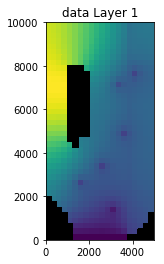

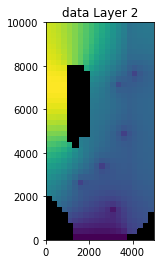

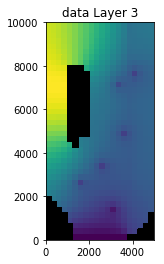

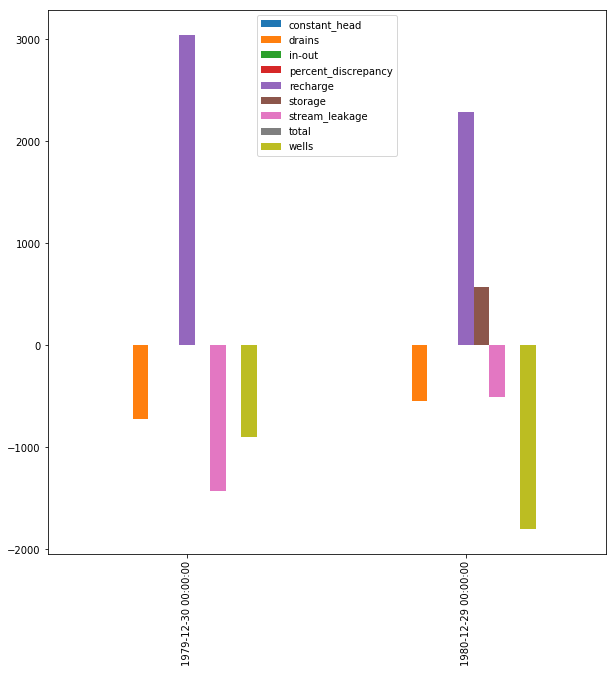

In [8]:
axes = hds.plot()
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))

In [9]:
props = []
paks = ["upw.hk","upw.vka","upw.ss","upw.sy"]
for k in range(m.nlay):
    props.extend([[p,k] for p in paks])
props.append(["rch.rech",0])
props.append(["rch.rech",1])


In [10]:
spatial_list_props = [["wel.flux",2],["drn.cond",0]]
temporal_list_props = [["wel.flux",0],["wel.flux",1]]

In [11]:
hds_kperk = [[0,k] for k in range(m.nlay)]
hds_kperk.extend([[1,k] for k in range(m.nlay)])

In [12]:
sfr_obs_dict = {"hw":np.arange(1,21)}
sfr_obs_dict["tw"] = np.arange(20,40)
for i in range(m.nrow):
    sfr_obs_dict[i] = i+1

In [13]:
pst_helper = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws="template",org_model_ws="temp",
                                            const_props=props,spatial_list_props=spatial_list_props,
                                             temporal_list_props=temporal_list_props,remove_existing=True,
                                            grid_props=props,sfr_pars=True,hds_kperk=hds_kperk,
                                             sfr_obs=sfr_obs_dict,build_prior=False,model_exe_name="mfnwt")

2019-04-23 20:01:48.902773 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam

--------------------------------------------------
External unit dictionary:
OrderedDict([(2, filename:temp/freyberg.list, filetype:LIST), (11, filename:temp/freyberg.dis, filetype:DIS), (13, filename:temp/freyberg.bas, filetype:BAS6), (31, filename:temp/freyberg.upw, filetype:UPW), (19, filename:temp/freyberg.rch, filetype:RCH), (32, filename:temp/freyberg.nwt, filetype:NWT), (14, filename:temp/freyberg.oc, filetype:OC), (30, filename:temp/freyberg.lmt6, filetype:LMT6), (20, filename:temp/freyberg.wel, filetype:WEL), (17, filename:temp/freyberg.sfr, filetype:SFR), (21, filename:temp/freyberg.drn, filetype:DRN), (50, filename:temp/freyberg.cbc, filetype:DATA(BINARY)), (51, filename:temp/freyberg.hds, filetype:DATA(BINARY)), (60, filename:temp/freyberg.sfr.out, filetype:DATA)])
-------------------

2019-04-23 20:01:50.858353 starting: writing const tpl:vka4.dat_cn.tpl
2019-04-23 20:01:50.865097 finished: writing const tpl:vka4.dat_cn.tpl took: 0:00:00.006744
2019-04-23 20:01:50.867942 starting: writing const tpl:ss4.dat_cn.tpl
2019-04-23 20:01:50.874510 finished: writing const tpl:ss4.dat_cn.tpl took: 0:00:00.006568
2019-04-23 20:01:50.878562 starting: writing const tpl:sy4.dat_cn.tpl
2019-04-23 20:01:50.887889 finished: writing const tpl:sy4.dat_cn.tpl took: 0:00:00.009327
2019-04-23 20:01:50.891873 starting: writing const tpl:hk5.dat_cn.tpl
2019-04-23 20:01:50.898792 finished: writing const tpl:hk5.dat_cn.tpl took: 0:00:00.006919
2019-04-23 20:01:50.902083 starting: writing const tpl:vka5.dat_cn.tpl
2019-04-23 20:01:50.908547 finished: writing const tpl:vka5.dat_cn.tpl took: 0:00:00.006464
2019-04-23 20:01:50.911179 starting: writing const tpl:ss5.dat_cn.tpl
2019-04-23 20:01:50.919023 finished: writing const tpl:ss5.dat_cn.tpl took: 0:00:00.007844
2019-04-23 20:01:50.922493 sta

noptmax: 0
2019-04-23 20:01:54.107517 starting: running pestchek on freyberg.pst
2019-04-23 20:01:54.604150 pestcheck:PESTCHEK Version 13.0. Watermark Numerical Computing.
2019-04-23 20:01:54.604794 pestcheck:
2019-04-23 20:01:54.605132 pestcheck:Errors ----->
2019-04-23 20:01:54.605200 pestcheck:No errors encountered.
2019-04-23 20:01:54.605256 pestcheck:
2019-04-23 20:01:54.605302 pestcheck:Warnings ----->
2019-04-23 20:01:54.605345 pestcheck:NUMLAM is supplied as negative. This will be reset to positive. If Parallel
2019-04-23 20:01:54.605616 pestcheck:PEST or BEOPEST is used PARLAM will automatically be set to -9999.
2019-04-23 20:01:54.605693 pestcheck:NOPTMAX provided as zero. No optimisation iterations will be carried out;
2019-04-23 20:01:54.605814 pestcheck:objective function and residuals will be recorded for initial parameter
2019-04-23 20:01:54.605891 pestcheck:estimates only.
2019-04-23 20:01:54.606018 pestcheck:MAXSING in the singular value decomposition section is greate

In [14]:
pst = pst_helper.pst
pst.npar,pst.nobs

(9943, 4434)

In [15]:
pst.parameter_data.pargp.value_counts()

grvka2         705
grss1          705
grrech0        705
grsy1          705
grhk1          705
grvka1         705
grss2          705
grrech1        705
grhk2          705
grss0          705
grhk0          705
grsy2          705
grvka0         705
grsy0          705
strk            40
drncond_k00     10
welflux_k02      6
welflux          2
hk3_cn           1
vka3_cn          1
hk5_cn           1
vka4_cn          1
rech3_cn         1
ss4_cn           1
ss3_cn           1
vka5_cn          1
hk4_cn           1
ss5_cn           1
rech2_cn         1
sy4_cn           1
flow             1
sy3_cn           1
sy5_cn           1
Name: pargp, dtype: int64

In [16]:
pst.observation_data.obgnme.value_counts()

hds            4230
flaqx            84
flout            84
vol_percent       2
flx_drains        2
vol_in-out        2
flx_wells         2
flx_in-out        2
vol_drains        2
flx_constan       2
vol_storage       2
vol_total         2
flx_stream_       2
vol_stream_       2
vol_wells         2
vol_constan       2
flx_storage       2
flx_percent       2
flx_recharg       2
flx_total         2
vol_recharg       2
Name: obgnme, dtype: int64

In [17]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=pst_helper.new_model_ws)

noptmax: 0


In [18]:
#pst_helper.build_prior()
pe = pst_helper.draw(200)

2019-04-23 20:02:01.831542 starting: drawing realizations
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

working on pargroups ['drncond_k00']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['welflux_k02']
build cov matrix
done
getting diag var cov 6
scaling full cov by diag var cov
making full cov draws with home-grown goodness


/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:180.0,anisotropy:1.0,bearing:0.0

working on pargroups ['welflux']
build cov matrix
done
getting diag var cov 2
scaling full cov by diag var cov
making full cov draws with home-grown goodness
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

working on pargroups ['grhk0']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grvka0']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grss0']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-grown goodness
working on pargroups ['grsy0']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
making full cov draws with home-g

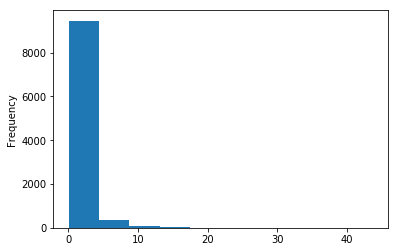

In [19]:
pe.iloc[0,:].plot(kind="hist")

In [21]:
pe.enforce()
pe.to_csv(os.path.join(pst_helper.new_model_ws,"sweep_in.csv"))

In [33]:
obs_locs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
obs_locs.loc[:,"obsnme"] = obs_locs.apply(lambda x: "hds_00_{0:03d}_{1:03d}_000".format(x.row-1,x.col-1),axis=1)
obs_locs

,row,col,obsnme
0,3,16,hds_00_002_015_000
1,3,10,hds_00_002_009_000
2,4,9,hds_00_003_008_000
3,10,2,hds_00_009_001_000
4,14,11,hds_00_013_010_000
5,16,17,hds_00_015_016_000
6,22,11,hds_00_021_010_000
7,23,16,hds_00_022_015_000
8,25,5,hds_00_024_004_000
9,27,7,hds_00_026_006_000


In [36]:
pst.observation_data.loc[:,"weight"] = 0.0
pst.observation_data.loc[obs_locs.obsnme,"weight"] = 1.0
pst.observation_data.loc[obs_locs.obsnme,"obgnme"] = "calhead"
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))

noptmax: 0


In [37]:
pyemu.os_utils.run("pestpp-ies.exe freyberg.pst",cwd=pst_helper.new_model_ws)